# A real-time combined sewer overflow (CSO) and pathogen warning system

## Stephen Klosterman

This consulting project for the 2017B session of the Insight Remote Data Science Fellows Program was conducted for the 
New York City Department of Environmental Protection (NYC DEP).  The goal is to inform a real-time warning system about when CSOs are happening, and when bacterial pathogen concentrations in public waterways are likely to be above concerning threshold levels.

*(Link to explanation of CSOs, federal regulations)*

The input data for the warning system are hourly rainfall measurements from the JFK Airport. *(Possibly other weather data available in real time)* .  The goals for the warning system are to

1.  Inform people of when CSO events are happening
2.  Inform them of when waterway pathogen concentrations are above threshold levels

The data for the project are hourly rainfall data from JFK airport for the period 2002-2012, as well as model outputs for CSO flows and waterway pathogen concentrations.  The CSO and pathogen models are not feasible to run in real time because not all of their inputs are available in real time.  Therefore the NYC DEP requires a regression, or other algorithmic, approach to predicting CSO flows and pathogen concentrations, using only real-time weather data as input.  NYC DEP has baseline regression models; I seek to create more accurate models.

*(Improve this to have hyperlinks)*
The structure of the notebook is to

1.  Exploring the rainfall/CSO flow relationship
2.  Implementing the baseline rainfall/CSO model
3.  Develop new rainfall/CSO model, compare accuracy
4.  Exploring the rainfall/pathogen relationship
5.  Implementing the baseline rainfall/pathogen
6.  Retrain rainfall/CSO model for rainfall/pathogen relationship 

In [30]:
#Import libraries
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

## 1. Explore rainfall/CSO relationship

First I load the data into a Pandas data frame, then format it for plotting

In [31]:
#Load the data.
path = './data/'

# #Takes ~ 1 minute to load spreadsheet
# fname = 'ci2002_2011pathogenLOADand2008nutrient_carbonLOAD_20170517D.xlsx'
# rain_cso_df = pd.read_excel(path + fname, sheetname='Outfall_pathogenLoad_part1', header=3, \
#                     index_col=2)

#Save time by saving/loading pickle
# rain_cso_df.to_pickle(path + 'rain_cso_df.pkl')

rain_cso_df = pd.read_pickle(path + 'rain_cso_df.pkl')

In [32]:
#What does it look like?
rain_cso_df.head()

,Station ID,Year,Fecal Coliform,Enterococcus,(in/hr),(MG/Hour)
(day),,,,,,
0.00000,OH-21C,2002,0.0,0.0,0.0,0.0
0.04167,OH-21C,2002,0.0,0.0,0.0,0.0
0.08333,OH-21C,2002,0.0,0.0,0.0,0.0
0.12500,OH-21C,2002,0.0,0.0,0.0,0.0
0.16667,OH-21C,2002,0.0,0.0,0.0,0.0


The variables of interest are (in/hr), which is rain fall in inches/hr, and (MG/Hour) which is outflow from the CSOs in millions of gallons per hour. (*Confirm this*).  The pathogens here, Fecal Coliform and Enterococcus, are estimates of the discharge from the CSO, not the waterway concentrations I'm utlimately interested in.

The first step is to break out the data from different stations.

In [33]:
#Unique station IDs in the data set... there are only two CSOs we are concerned with
np.unique(rain_cso_df['Station ID'])

array([u'CI-601', u'CI-602', u'OH-015', u'OH-21C', u'OH-21S', u'OH-875'], dtype=object)

In [34]:
rain_cso_df.shape

(525888, 6)

*Probably the optimal way to do this is to actually make two columns in this dataframe for the two CSOs, if all the times are the same, and then add in all the water quality data to the same dataframe... the times are the same, so this seems the way to go.  Rainfalls are also the same, so this only needs done once as well*

In [35]:
#Start off dataframe by subsetting to only one of the repetitions of the year series
cso_qual_df = rain_cso_df.filter(['Year'])
mask = rain_cso_df['Station ID'].isin(['CI-601'])
cso_qual_df = cso_qual_df[mask]

cso_qual_df['CSO 1, MG/hr'] = rain_cso_df[rain_cso_df['Station ID'].isin(['OH-015'])]['(MG/Hour)']
cso_qual_df['CSO 2, MG/hr'] = rain_cso_df[rain_cso_df['Station ID'].isin(['OH-21C'])]['(MG/Hour)']
cso_qual_df['Rain, in/hr'] = rain_cso_df[rain_cso_df['Station ID'].isin(['CI-602'])]['(in/hr)']

In [36]:
cso_qual_df.shape

(87648, 4)

In [37]:
#Create array of datetime objects to use in dataframe index, and for plotting
#Include rounding of days for whole number hours

helper = np.vectorize(lambda x: datetime.timedelta(hours=x))
start_day = datetime.datetime(2002, 1, 1)
#Change index to hours from days and round to whole hours
cso_qual_df.index = np.round(cso_qual_df.index.values*24.)
time_array = helper(cso_qual_df.index) + start_day
cso_qual_df.index = time_array

In [38]:
cso_qual_df.head()

,Year,"CSO 1, MG/hr","CSO 2, MG/hr","Rain, in/hr"
2002-01-01 00:00:00,2002,0.0,0.0,0.0
2002-01-01 01:00:00,2002,0.0,0.0,0.0
2002-01-01 02:00:00,2002,0.0,0.0,0.0
2002-01-01 03:00:00,2002,0.0,0.0,0.0
2002-01-01 04:00:00,2002,0.0,0.0,0.0


Now that I've got the data separated into dataframes for each CSO, I do some exploratory visualization.  First, how often do overflows from the CSOs occur?  I plot the time series of CSO overflows for all ten years.

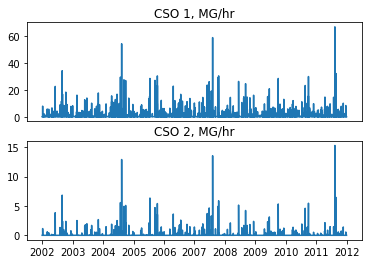

In [39]:
#Visualize CSO flow over time across the ten years
#Plots of CSO outflow over time for both CSOs
plt.subplot(211)
plt.plot(time_array, cso_qual_df['CSO 1, MG/hr'])
plt.title('CSO 1, MG/hr')
plt.xticks([]);
plt.subplot(212)
plt.plot(time_array, cso_qual_df['CSO 2, MG/hr'])
plt.title('CSO 2, MG/hr')

The CSOs both appear to overflow on a regular basis over the 10 years.  They overflow at similar times, but the magnitudes are larger in the first one.  I take a closer look, at a two day period, of both CSO flow and rainfall for the second one:

In [40]:
#Mask time series for closer look at data
plot_index = 0 #0 or 1 for either CSO

#Begin and end times for mask
mask_start_time = datetime.datetime(2011, 8, 27)
mask_end_time = datetime.datetime(2011, 8, 29)

#Vectorized way to apply test to every item of the list for a mask array
mask_series = np.vectorize(lambda testday, begin, stop: (testday >= begin) & (testday <= stop))
mask = mask_series(time_array, mask_start_time, mask_end_time)

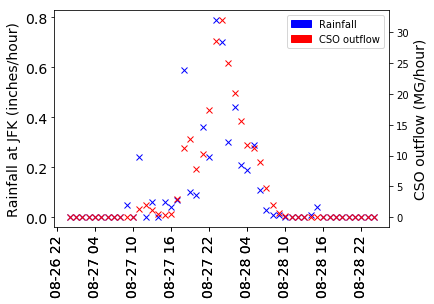

In [41]:
#Plot the rainfall and CSO outflow series

# create the general figure
fig1 = plt.figure()
font_size = 14
 
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)
line1 = ax1.plot(time_array[mask], \
                 cso_qual_df['Rain, in/hr'][mask], 'bx')
plt.ylabel("Rainfall at JFK (inches/hour)", fontsize=font_size)
 
# now, the second axes that shares the x-axis with the ax1
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
line2 = ax2.plot(time_array[mask], \
                 cso_qual_df['CSO 1, MG/hr'][mask], 'rx')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.ylabel("CSO outflow (MG/hour)", fontsize=font_size)

#Adjust tick labels
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=90, fontsize=font_size)
labels = ax2.get_xticklabels()
plt.setp(labels, rotation=90, fontsize=font_size)
ax1.tick_params(labelsize=font_size)

#Make legend using proxy artist
blue_patch = mpl.patches.Patch(color='blue', label='Rainfall')
red_patch = mpl.patches.Patch(color='red', label='CSO outflow')
plt.legend(handles=[blue_patch, red_patch])

# plt.title(cso_names[plot_index])

plt.show()

It seems clear that rainfall events happen about the same time as overflow events.  It also looks like the overflow lasts a little while after the end of the rain event.  This makes sense because the sewer system would be full of storm water and sanitary sewage, and need some time to drain.

Now to get a broader view of what the relation of rainfall to CSO outflow is, let's look at scatter plots between these two variables over the 10 year time frame for both sewers, and calculate their correlation coefficients.

In [42]:
#Define a little function to plot any column against rainfall as a scatter and display
#correlation, and use it twice
def cso_scatter(column_name):
    title_str = column_name + ': r = %0.2f' % \
          cso_qual_df['Rain, in/hr'].\
          corr(cso_qual_df[column_name])
    cso_qual_df.plot.scatter(x='Rain, in/hr', y=column_name)
    plt.title(title_str)
    

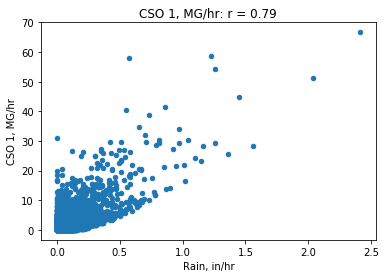

In [43]:
cso_scatter('CSO 1, MG/hr')

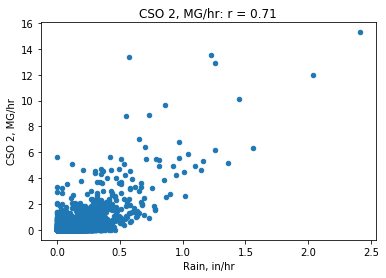

In [44]:
cso_scatter('CSO 2, MG/hr')

Concurrent rainfall and CSO overflows are highly correlated.  In order to alert the public to when CSOs are happening, I could simply propose to let them know any time it was raining.  However since I saw that a CSO event could last after a rainfall event, a better approach is likely possible, using not only current, but historical rainfall data as well.  In the next section, I implement the NYC DEP's existing baseline model for this. Then in the following section, I explore another time series modeling approach.

### Framing as a classification problem

First, though, as a final data exploration step, I binarize the cso outflow data:  any time when a CSO is occurring is labeled "1", and when it's not occuring is labeled "0".  This facilitates modeling with the ultimate deliverable in mind:  a warning system for when CSOs are occurring, versus when they're not.

First I explore the class proportion of this classification problem:

In [45]:
cso_occur = np.sum(cso_qual_df['CSO 1, MG/hr']>0)
no_cso = np.sum(cso_qual_df['CSO 1, MG/hr']==0)
print('Fraction of CSO events in data set is {:0.2f}'\
      .format(np.float(cso_occur)/len(cso_qual_df['CSO 1, MG/hr'].values)))

Fraction of CSO events in data set is 0.19


So there is a class imbalance, although the ratio of CSO events to non-events is 1 to 4 so it may not be severe enough to hamper performance.  Now I binarize the CSO outflow data:

In [46]:
cso_qual_df.loc[cso_qual_df['CSO 1, MG/hr'] > 0, 'CSO 1, MG/hr'] = 1
cso_qual_df.loc[cso_qual_df['CSO 2, MG/hr'] > 0, 'CSO 2, MG/hr'] = 1

In [47]:
cso_qual_df.head(1000)

,Year,"CSO 1, MG/hr","CSO 2, MG/hr","Rain, in/hr"
2002-01-01 00:00:00,2002,0.0,0.0,0.00
2002-01-01 01:00:00,2002,0.0,0.0,0.00
2002-01-01 02:00:00,2002,0.0,0.0,0.00
2002-01-01 03:00:00,2002,0.0,0.0,0.00
2002-01-01 04:00:00,2002,0.0,0.0,0.00
2002-01-01 05:00:00,2002,0.0,0.0,0.00
2002-01-01 06:00:00,2002,0.0,0.0,0.00
2002-01-01 07:00:00,2002,0.0,0.0,0.00
2002-01-01 08:00:00,2002,0.0,0.0,0.00
2002-01-01 09:00:00,2002,0.0,0.0,0.00


## XX. Baseline method for predicting CSO events

The NYC DEP's method for calculating combined sewer overflow events is based on the amount of time after a rainfall event.  Here, a rainfall event is defined as any period of rainfall that is separated by at least four hours from another period of rainfall.  The rainfall events are contained in a spreadsheet which I load here:

In [48]:
# #Load rainfall events data
# fname = '2002 to 2011 Storm Event Summary.xlsx'
# rain_events_df = pd.read_excel(path + fname, sheetname='2002 to 2011 Summary', header=0, \
#                     index_col=0)

#Pickle
# rain_events_df.to_pickle(path + 'rain_events_df.pkl')
rain_events_df = pd.read_pickle(path + 'rain_events_df.pkl')

In [49]:
#Drop unnecessary rows, show head of dataframe
rain_events_df.drop(rain_events_df.index[[0, 1, 2, 3]], inplace=True)
rain_events_df.head()

,Event End,Event Duration (hrs),Peak Intensity (in/hour),Total Rainfall depth (in),Time of Peak
Event Start,,,,,
2002-01-06 17:00:00,2002-01-06 22:00:00,5.0,0.26,0.75,2002-01-06 19:00:00
2002-01-07 12:00:00,2002-01-07 13:00:00,1.0,0.01,0.01,2002-01-07 12:00:00
2002-01-07 17:00:00,2002-01-07 21:00:00,4.0,0.01,0.04,2002-01-07 17:00:00
2002-01-09 10:00:00,2002-01-09 15:00:00,5.0,0.04,0.10,2002-01-09 14:00:00
2002-01-11 07:00:00,2002-01-11 13:00:00,6.0,0.06,0.21,2002-01-11 09:00:00


The baseline model assumes CSO events happen for a period of twelve hours after the end of each rain event.  This is implemented here as an array of 1's, for times during a CSO event, and 0's elsewhere.

In [50]:
#Boolean mask with location in the cso_qual_df of where rain event end times are
#This has length the same as cso_qual_df and sum equal to the length of rain_events_df
event_end_mask = cso_qual_df.index.isin(rain_events_df['Event End'].values)
#Integer indices of the above, event_end_indices[0] has length equal to rain_events_df
event_end_indices = np.nonzero(event_end_mask)

In [51]:
#The baseline model for when there is a CSO happening.  Start with all zeros
baseline_cso = np.zeros(cso_qual_df.shape[0])
#Then for every index in event_end_indices, make that element and the subsequent eleven elements into ones
for event_end_index in event_end_indices[0]:
    baseline_cso[event_end_index:event_end_index+12] = 1
# sum(baseline_cso)/12 = 1128.1666666666667, while len(rain_events_df) = 1191
#seems to imply some rain events start before the 12 hours after the last one is over

Now I have the baseline model, which is the same for all CSOs.  I calculate the accuracy as fraction of model values that are correct.

In [52]:
baseline_acc = np.empty(2,)
baseline_acc[0] = sum(cso_qual_df['CSO 1, MG/hr'].values == baseline_cso)/np.float(len(baseline_cso))
baseline_acc[1] = sum(cso_qual_df['CSO 2, MG/hr'].values == baseline_cso)/np.float(len(baseline_cso))

print('Accuracy of baseline model for CSO 1: {:0.2f}, CSO 2: {:0.2f}'.format(baseline_acc[0],  baseline_acc[1]))

Accuracy of baseline model for CSO 1: 0.85, CSO 2: 0.84


## 2. Modeling CSO flow from rainfall data

In [53]:
#Split data into 10 separate years; do this for both CSOs.
#Training data will be 1st through 9th years, testing 2nd through 10th.

#Get unique years
un_years = np.unique(cso_qual_df['Year'])
print(un_years, 'length', len(un_years))

(array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]), 'length', 10)


In [78]:
#Function that takes:
#model: sklearn model for traning and testing
#lag_order: positive integer, number of time lags to include in addition to current point in model
#column_to_model: column name from Pandas dataframe that will be used as response variable
#
#Returns:  all_test_acc, numpy array of accuracies for each train/test instance (9 of them)
def train_and_test(model, lag_order, column_to_model):
    sep_years_data = [None]*len(un_years)
    #For storing trained models
    est = [None]*len(un_years)

    #Loop to train separately on each year
    for year_index in range(len(un_years)):
        #Subset the data to the desired year
        sep_years_data[year_index] = \
            cso_qual_df[cso_qual_df['Year'].isin([un_years[year_index]])]

        #Filter out columns not used
        sep_years_data[year_index] = sep_years_data[year_index].filter\
            (['Rain, in/hr', column_to_model], axis=1)

        #Create time lagged columns for predictor matrix
        for n_pred_columns in range(1,lag_order+1):

                sep_years_data[year_index].insert\
                (0, 'Lag '+ str(n_pred_columns),\
                 sep_years_data[year_index]['Rain, in/hr'].shift(n_pred_columns))

        #Drop rows with NA that were introduced by shifting to get lags
        sep_years_data[year_index].dropna(axis=0, inplace=True)

        #Now make arrays of predictors and response.
        X = sep_years_data[year_index].drop([column_to_model], axis=1).values
        y = sep_years_data[year_index].filter([column_to_model], axis=1).values
#         print(np.shape(y))       
        #Fit model in sklearn
        est[year_index] = model.fit(X, y)
        
            
    ##
    ## Model testing
    X_next = [None]*len(un_years)
    y_next_pred = [None]*len(un_years)
    y_next = [None]*len(un_years)
    all_test_acc = np.array([])
    
    #Loop to test on the next year, using the current year's parameters
    for j in range(len(un_years)-1):
        #Get next year's predictors
        X_next[j] = sep_years_data[j+1].drop([column_to_model], axis=1).values
        #Do prediction using this year's parameters
        y_next_pred[j] = est[j].predict(X_next[j])
        #Get actual values from next year
        y_next[j] = \
        sep_years_data[j+1].filter([column_to_model], axis=1)[column_to_model].values

#         print(np.shape(y_next_pred[i][j]), np.shape(y_next[i][j]))
        
        #Is this the same as percent of correct classifications?
        #Appears to be yes; these two versions produce apparently identical results
#         all_test_r_sq = np.append(all_test_r_sq, np.sum(y_next_pred[j] == y_next[j]) / np.float(len(y_next[j])))
        
        all_test_acc = np.append(all_test_acc, est[j].score(X_next[j], y_next[j]))
    return all_test_acc




I first examine the logistic regression model for classifying times as CSO events or not.  I don't know what the best number of lags is to include as predictors, so I start with one lag and try up to fifteen.  Intuitively I expect the addition of more lags to improve the model, up to a point:  rainfall too far in the past probably has nothing to do with an overflow event right now.  The question is how far back is needed:

In [112]:
#if using sklearn
#*** Good to specify and justify all parameters here, may want to do 2D model
#validation on lags and C parameter, can have heatmap
from sklearn import linear_model
logistic_reg_model = linear_model.LogisticRegression(fit_intercept = True, C=1000000)

#Different numbers of lags to explore
several_lags = range(1,15)
#Arrays to store accuracy of models
many_lag_acc = []
mean_acc = np.array([])
std_acc = np.array([])
#Train and test the models
for each_lag in several_lags:
    tmp_val = train_and_test(logistic_reg_model, each_lag, 'CSO 1, MG/hr')
    many_lag_acc.append(tmp_val)
    mean_acc = np.append(mean_acc, np.mean(tmp_val))
    std_acc = np.append(std_acc, np.std(tmp_val))
#     print(each_lag)

In [113]:
mean_acc

array([ 0.90152473,  0.91619543,  0.92698881,  0.93069645,  0.9369408 ,
        0.94167762,  0.94533746,  0.94752609,  0.94825586,  0.94860554,
        0.94853596,  0.94846668,  0.94871516,  0.9486204 ])

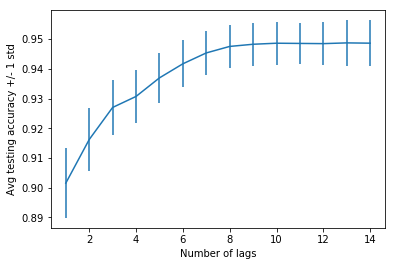

In [114]:
# plt.plot(several_lags, mean_r_sq)
plt.errorbar(several_lags, mean_acc, yerr=std_acc)
plt.xlabel('Number of lags')
plt.ylabel('Avg testing accuracy +/- 1 std')
plt.title('')

In the case of CSO 1, there is a noticeable improvement in classification accuracy up to about 10 lags.  I use this as the basis to explore another classification model, a random forest classifier.  In this case, I will vary parameters of the underlying decision trees (eg maximum depth, minimum number of samples at a leaf).

In [123]:
#Import and instantiate model
from sklearn import ensemble
ran_for_model = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None,\
                                min_samples_split=2,\
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',\
                                max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False,
                                n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)

In [124]:
#Different numbers of lags to explore
lag = 10
#Arrays to store accuracy of models
ran_for_acc = []
mean_acc = np.array([])
std_acc = np.array([])
#Train and test the models
# for each_lag in several_lags:
tmp_val = train_and_test(ran_for_model, lag, 'CSO 1, MG/hr')
ran_for_acc.append(tmp_val)
mean_acc = np.append(mean_acc, np.mean(tmp_val))
std_acc = np.append(std_acc, np.std(tmp_val))

/Users/Steve/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [125]:
mean_acc

array([ 0.95337868])

Random forest with 100 trees and otherwise default parameters provides little increase in accuracy over the logistic regression model.

## Exploratory analysis and baseline method for predicting bacteria events



In [94]:
#Load pathogen data and add it to the data frame

# fname = 'ci_baseline_2002_2011pathogen_and_2008dissolved_oxygen_20170509B.xlsx'
# patho_df = pd.read_excel(path + fname, sheetname='ten_year_pathogen', header=3, \
#                     index_col=2)

#Pickle for faster loading
# patho_df.to_pickle(path + 'patho_df.pkl')  # where to save it, usually as a .pkl
patho_df = pd.read_pickle(path + 'patho_df.pkl')

In [95]:
patho_df.head()

,Station ID,Year,Fecal Coliform,Enterococcus,Station ID.1,Fecal Coliform.1,Enterococcus.1,Station ID.2,Fecal Coliform.2,Enterococcus.2,(in/hr)
(day),,,,,,,,,,,
0.00000,CIC2,2002,44,30,CIC3,37,19,GB1,28,7,0.0
0.04167,CIC2,2002,44,30,CIC3,37,19,GB1,29,7,0.0
0.08333,CIC2,2002,41,27,CIC3,36,19,GB1,31,8,0.0
0.12500,CIC2,2002,39,25,CIC3,35,17,GB1,36,10,0.0
0.16667,CIC2,2002,38,25,CIC3,34,17,GB1,38,11,0.0


In [96]:
# patho_df.columns

In [97]:
#Need to find

#Maximum FC concentration in the 12 hours following end of rainfall event (my interpretation, need
#something to get warning started)

#FC concentrations at 12, 24, 36, and 48 hours after.  Each will be used to define warning status for the 11
#hours after that time point (my interpretation).  Assumption that warning ends at 60 hours.

fc_max_in_12_h = np.empty(np.shape(event_end_indices[0]))
fc_12_h = np.empty(np.shape(event_end_indices[0]))
fc_24_h = np.empty(np.shape(event_end_indices[0]))
fc_36_h = np.empty(np.shape(event_end_indices[0]))
fc_48_h = np.empty(np.shape(event_end_indices[0]))

#Select column name to get baseline model accuracy score
column_name = 'Fecal Coliform'

counter = 0

for event_end_index in event_end_indices[0]:
    fc_max_in_12_h[counter] = np.max(patho_df[column_name].iloc[event_end_index:event_end_index+12])
    fc_12_h[counter] = patho_df[column_name].iloc[event_end_index+12]
    fc_24_h[counter] = patho_df[column_name].iloc[event_end_index+24]
    fc_36_h[counter] = patho_df[column_name].iloc[event_end_index+36]
    fc_48_h[counter] = patho_df[column_name].iloc[event_end_index+48]

    counter = counter + 1

#Now each one of these gets its own linear model with rainfall event volume
ols_model = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
#Predictor is volume of rainfall event
rainfall_depth = rain_events_df['Total Rainfall depth                 (in)'].values.reshape(-1,1)

model_12_hr_max = ols_model.fit(rainfall_depth, fc_max_in_12_h)
model_12_hr = ols_model.fit(rainfall_depth, fc_12_h)
model_24_hr = ols_model.fit(rainfall_depth, fc_24_h)
model_36_hr = ols_model.fit(rainfall_depth, fc_36_h)
model_48_hr = ols_model.fit(rainfall_depth, fc_48_h)

#Build array using predicted concentration at each time interval, throughout that interval
#after each rainfall event
#Zero
baseline_fc_model = np.zeros(np.shape(patho_df[column_name].values))
#Except after rainfall events
counter = 0
for event_end_index in event_end_indices[0]:
    this_rainfall_val = rainfall_depth[counter].reshape(1,-1)
    baseline_fc_model[event_end_index:event_end_index+12] = model_12_hr_max.predict(this_rainfall_val)
    baseline_fc_model[event_end_index+12:event_end_index+24] = model_12_hr.predict(this_rainfall_val)
    baseline_fc_model[event_end_index+24:event_end_index+36] = model_24_hr.predict(this_rainfall_val)
    baseline_fc_model[event_end_index+36:event_end_index+48] = model_36_hr.predict(this_rainfall_val)
    baseline_fc_model[event_end_index+48:event_end_index+60] = model_48_hr.predict(this_rainfall_val)
    
    counter = counter + 1
    
#Set negatives to zero
baseline_fc_model[baseline_fc_model<0] = 0

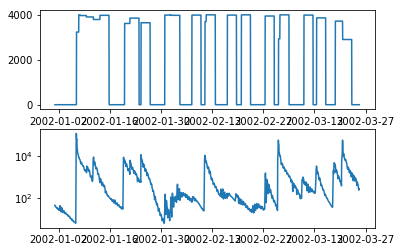

In [98]:
#Sanity check, these should be simulated bacteria events, according to the baseline model
plt.subplot(2,1,1)
plt.plot(cso_qual_df.index.values[0:2000], baseline_fc_model[0:2000])
#And this is the data set
plt.subplot(2,1,2)
plt.plot(cso_qual_df.index.values[0:2000], patho_df[column_name].iloc[0:2000])
plt.yscale('log')
#Looks reasonable, at least in timing

Now I binarize the predictions and data, and determine accuracy for finding times when FC > 1000

In [99]:
baseline_fc_model_bin = baseline_fc_model > 1000
data_bin = patho_df[column_name].values > 1000
baseline_fc_accuracy = sum(baseline_fc_model_bin == data_bin)/float(len(baseline_fc_model_bin))
print('Accuracy of baseline bacteria model is {:0.2f}'.format(baseline_fc_accuracy))

Accuracy of baseline bacteria model is 0.67


Accuracy for three time series is 0.67, 0.58, and 0.50.  These are considerably lower than the modeling results below, which allows me to claim a big improvement.  However, need to check I'm implementing baseline model correctly; the modeled concentrations are quite low.

Just looking here:  https://en.wikipedia.org/wiki/Semi-log_plot

It seems like from the shape of the plot in the hydroqual word doc like the shape of the curve is similar to log_10(x)... I'm not sure this makes much sense, although maybe they used that as a predictor?  Who knows.  Need to ask.

## Model the quality data

For this project I am interested in whether Fecal Coliform (FC) concentrations at representative model grid cells are at or above 1000 colonies/100 mL, or not.  So first I binarize the data according to this, and add it to the data frame with the CSO volumes, in order to use the same modeling functions.

In [100]:
regulation_limit = 1000. #this could be updated if regulations change

cso_qual_df['Fecal Coliform 1'] = patho_df['Fecal Coliform'].values
cso_qual_df.loc[cso_qual_df['Fecal Coliform 1'] < regulation_limit, 'Fecal Coliform 1'] = 0
cso_qual_df.loc[cso_qual_df['Fecal Coliform 1'] >= regulation_limit, 'Fecal Coliform 1'] = 1

cso_qual_df['Fecal Coliform 2'] = patho_df['Fecal Coliform.1'].values
cso_qual_df.loc[cso_qual_df['Fecal Coliform 2'] < regulation_limit, 'Fecal Coliform 2'] = 0
cso_qual_df.loc[cso_qual_df['Fecal Coliform 2'] >= regulation_limit, 'Fecal Coliform 2'] = 1

cso_qual_df['Fecal Coliform 3'] = patho_df['Fecal Coliform.2'].values
cso_qual_df.loc[cso_qual_df['Fecal Coliform 3'] < regulation_limit, 'Fecal Coliform 3'] = 0
cso_qual_df.loc[cso_qual_df['Fecal Coliform 3'] >= regulation_limit, 'Fecal Coliform 3'] = 1

In [101]:
cso_qual_df.head()
# patho_df.shape

,Year,"CSO 1, MG/hr","CSO 2, MG/hr","Rain, in/hr",Fecal Coliform 1,Fecal Coliform 2,Fecal Coliform 3
2002-01-01 00:00:00,2002,0.0,0.0,0.0,0,0,0
2002-01-01 01:00:00,2002,0.0,0.0,0.0,0,0,0
2002-01-01 02:00:00,2002,0.0,0.0,0.0,0,0,0
2002-01-01 03:00:00,2002,0.0,0.0,0.0,0,0,0
2002-01-01 04:00:00,2002,0.0,0.0,0.0,0,0,0


In [102]:
len(cso_qual_df['Fecal Coliform 1'])
n_FC_events = np.sum(cso_qual_df['Fecal Coliform 1'].values)
print('Fraction of bacteria events in data is {:0.2f}'.\
      format(np.float(n_FC_events)/len(cso_qual_df['Fecal Coliform 1'])))

Fraction of bacteria events in data is 0.29


So the classes are more balanced than with the CSO data.

Let's plot the binarized FC concentrations versus rainfall volumes for the first grid cell.

*even with log scale, this is not a good plot.  two histograms would probably be better*
*ditto for the volumes data*

Probably the coolest plot would be a histogram with baseline of zero for the zeros, an upside down one with baseline of 1 for the others, and a logistic function between them showing the regression... although there are many predictors so this is not a 2d plot.  Not sure exactly what to do here.... maybe choose predictor with largest coefficient and plot versus that?  Or do I actually need a plot?

(0.002, 4)

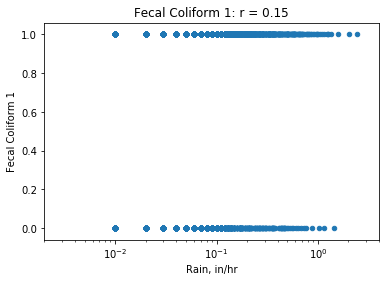

In [103]:
cso_scatter('Fecal Coliform 1')
plt.xscale('log')
plt.xlim([0.002, 4])

In [108]:
# sep_cso_df[1]
# sep_years_data[1][1]
several_lags = range(1,40)
# several_lags
many_lag_acc = []
mean_acc = np.array([])
std_acc = np.array([])
for each_lag in several_lags:
    tmp_val = train_and_test(logistic_reg_model, each_lag, 'Fecal Coliform 1')
    many_lag_acc.append(tmp_val)
    mean_acc = np.append(mean_acc, np.mean(tmp_val))
    std_acc = np.append(std_acc, np.std(tmp_val))

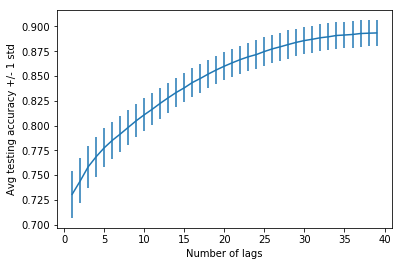

In [109]:
# plt.plot(several_lags, mean_r_sq)
plt.errorbar(several_lags, mean_acc, yerr=std_acc)
plt.xlabel('Number of lags')
plt.ylabel('Avg testing accuracy +/- 1 std')
plt.title('')

While the outflow model improved up to only about 10 lags, the bacteria model improves up to about 40.

Try random forest.

In [118]:
#Different numbers of lags to explore
lag = 35
#Arrays to store accuracy of models
ran_for_acc = []
mean_acc = np.array([])
std_acc = np.array([])
#Train and test the models
# for each_lag in several_lags:
tmp_val = train_and_test(ran_for_model, lag, 'Fecal Coliform 1')
ran_for_acc.append(tmp_val)
mean_acc = np.append(mean_acc, np.mean(tmp_val))
std_acc = np.append(std_acc, np.std(tmp_val))

/Users/Steve/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [119]:
mean_acc

array([ 0.89929627])

Here as in the outflow modeling, the random forest doesn't seem to provide much additional accuracy over a logistic regression.